# Exploring Dandiset 000617: Allen Institute Openscope - Sequence Learning Project

**WARNING: This notebook was generated by AI and has not been fully verified. Use caution when interpreting code or results.**

---

## Overview
This notebook explores [Dandiset 000617 (version 0.250312.0130)](https://dandiarchive.org/dandiset/000617/0.250312.0130), titled **Allen Institute Openscope - Sequence Learning Project**. The project examines predictive neural coding in mouse neocortex during sequence learning using two-photon calcium imaging. Mice viewed repeated sequences of natural movie clips, and neural/somatic responses were chronicled across sessions using 2-photon imaging and running measurements.

## Notebook Aims
- Summarize the contents and structure of a selected NWB file in this Dandiset.
- Demonstrate how to load and inspect calcium imaging data, ROI segmentation, stimulus intervals, and behavioral signals.
- Reproduce key visualizations: ROI mask overlays, sample dF/F calcium traces, and stimulus presentation timing histograms.
- Highlight how to access, visualize, and contextualize data for further analysis.

**Caution:** Some data are large—subsets are loaded for illustration.

## Required Packages
The Python packages required to run this notebook are:
- pynwb
- h5py
- remfile
- numpy
- pandas
- matplotlib

These are assumed to be installed on your system.

In [1]:
# Load Dandiset metadata using DANDI API
from itertools import islice
from dandi.dandiapi import DandiAPIClient

client = DandiAPIClient()
dandiset = client.get_dandiset("000617", "0.250312.0130")
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")

assets = dandiset.get_assets()
print("\nFirst 5 assets in Dandiset:")
for asset in islice(assets, 5):
    print(f"- {asset.path} (ID: {asset.identifier})")

Dandiset name: Allen Institute Openscope - Sequence Learning Project
Dandiset URL: https://dandiarchive.org/dandiset/000617/0.250312.0130

First 5 assets in Dandiset:
- sub-684475/sub-684475_ses-1294084428-acq-1294179945-raw-movies_ophys.nwb (ID: 3eaf1acf-7a63-4286-a7c0-7a58d8cae2f8)
- sub-684475/sub-684475_ses-1294084428-acq-1294179943-raw-movies_ophys.nwb (ID: 4cfa15bb-eac7-4273-9141-6d0cc2034506)
- sub-684475/sub-684475_ses-1293785946-acq-1293914859-raw-movies_ophys.nwb (ID: d0b9a557-2c98-4fbc-af96-2318e6e5f2eb)
- sub-684475/sub-684475_ses-1294084428-acq-1294179942-raw-movies_ophys.nwb (ID: 6b8f9ba6-2481-4c7b-b78c-38c2b878d246)
- sub-684475/sub-684475_ses-1294259213-acq-1294370666-raw-movies_ophys.nwb (ID: c407d5e4-9431-4f94-b5d0-2b28069fa244)


## Working with a Selected NWB File

We next focus on one NWB file to illustrate data contents and typical analysis. The file used is:

**sub-677038/sub-677038_ses-1280089433-acq-1280384858_ophys.nwb**

(Asset ID: `27dd7936-b3e7-45af-aca0-dc98b5954d19`)

URL for this asset:  
https://api.dandiarchive.org/api/assets/27dd7936-b3e7-45af-aca0-dc98b5954d19/download/

[View this NWB file on Neurosift](https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/27dd7936-b3e7-45af-aca0-dc98b5954d19/download/&dandisetId=000617&dandisetVersion=draft)

In [2]:
# Load the NWB file using PyNWB and remfile (streaming remote file)
import pynwb
import h5py
import remfile
import numpy as np
import pandas as pd

url = "https://api.dandiarchive.org/api/assets/27dd7936-b3e7-45af-aca0-dc98b5954d19/download/"

remote_file = remfile.File(url)
h5_file = h5py.File(remote_file, "r")
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

print(f"NWB identifier: {nwb.identifier}")
print(f"Session start: {nwb.session_start_time}")
print(f"Subject ID: {nwb.subject.subject_id}   Species: {nwb.subject.species}")

NWB identifier: 1280384858
Session start: 2023-06-30 16:04:51.055000+00:00
Subject ID: 677038   Species: Mus musculus


## Summary of File Structure and Metadata

The file contains processed optical physiology (ophys) data, ROI/cell segmentation, stimulus intervals, and running/behavioral measurements. Below is a summary of the ROI/cell segmentation table.

| Field Name            | Description                                                   |
|----------------------|---------------------------------------------------------------|
| `cell_specimen_id`   | Unified cell ID                                               |
| `height`/`width`     | ROI dimensions (pixels)                                       |
| `mask_image_plane`   | Identity for non-overlapping ROI mapping                      |
| `max_correction_*`   | Max motion correction values in pixels (4 directions)         |
| `valid_roi`          | Boolean, indicates if ROI passes cell classification          |
| `x`/`y`              | ROI top-left position in image plane (pixels)                 |
| `image_mask`         | 2D Boolean mask defining ROI shape within the field of view   |

Let's inspect table shape and a sample:

In [3]:
roi_table = nwb.processing['ophys'].data_interfaces['dff'].roi_response_series['traces'].rois.table
df_info = roi_table.to_dataframe()
print(f"ROI Table: {df_info.shape[0]} ROIs x {df_info.shape[1]} fields")
print("First 5 ROIs:\n", df_info.head())

ROI Table: 121 ROIs x 12 fields
First 5 ROIs:
             cell_specimen_id  height  mask_image_plane  max_correction_down  \
id                                                                            
1285902696                -1      22                 1                  4.0   
1285902717                -1      18                 1                  4.0   
1285902742                -1      19                 1                  4.0   
1285902805                -1      22                 0                  4.0   
1285902819                -1      20                 0                  4.0   

            max_correction_left  max_correction_right  max_correction_up  \
id                                                                         
1285902696                 18.0                   5.0               23.0   
1285902717                 18.0                   5.0               23.0   
1285902742                 18.0                   5.0               23.0   
1285902805         

## Visualization: Overlay of ROI Masks on Max Projection Image

This plot overlays all segmented ROI masks on the max projection image of the two-photon field of view.

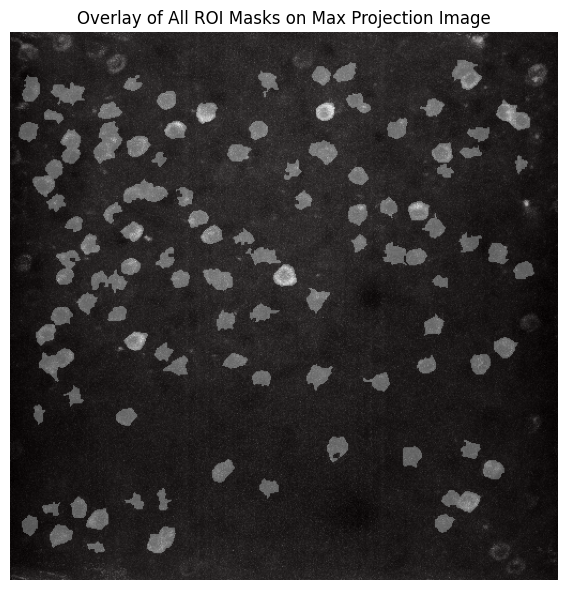

In [4]:
import matplotlib.pyplot as plt

roi_masks = np.array(roi_table.image_mask)  # (121, 512, 512), boolean
img_module = nwb.processing['ophys'].data_interfaces["images"]
max_proj = img_module.images["max_projection"].data[:]
if max_proj.shape != (512, 512):
    max_proj = max_proj.T

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(max_proj, cmap="gray")
mask_heatmap = np.max(roi_masks, axis=0)
ax.imshow(mask_heatmap, cmap="hot", alpha=0.3)
ax.set_title("Overlay of All ROI Masks on Max Projection Image")
ax.axis("off")
plt.tight_layout()
plt.show()

_The above visualization reveals the spatial layout and coverage of segmentation across the imaging area. ROIs are distributed fairly broadly, with some denser and sparser regions, and minimal overlap._

## dF/F Calcium Traces for Sample ROIs

Here are example calcium activity traces (dF/F) for six ROIs, chosen in order from the segmentation table. This highlights temporal diversity in neural responses.

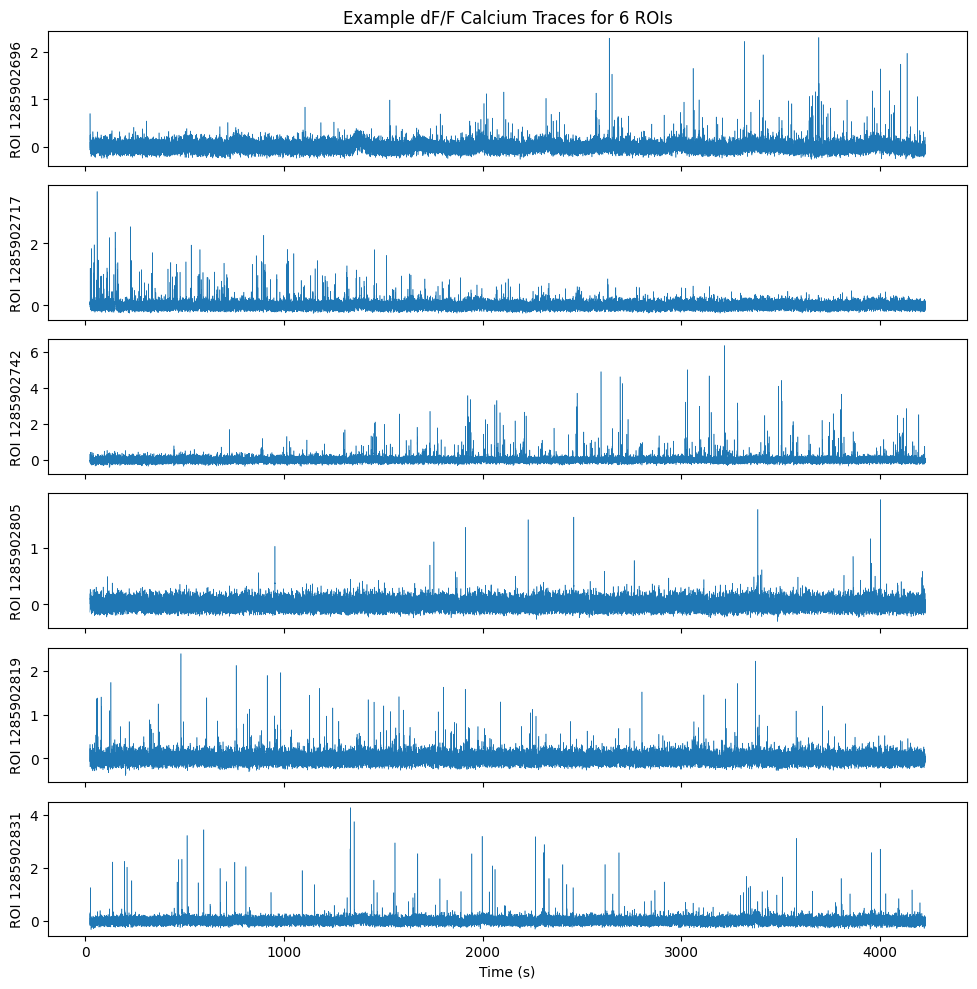

In [5]:
dff = nwb.processing['ophys'].data_interfaces['dff'].roi_response_series['traces']
timestamps = dff.timestamps[:]
data = dff.data[:, :6]  # (frames, 6)
roi_ids = list(dff.rois.table.id[:6])

fig, axs = plt.subplots(6, 1, figsize=(10, 10), sharex=True)
for i in range(6):
    axs[i].plot(timestamps, data[:, i], lw=0.4)
    axs[i].set_ylabel(f'ROI {roi_ids[i]}')
axs[0].set_title('Example dF/F Calcium Traces for 6 ROIs')
axs[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

_Note the pronounced diversity in trace shape and event frequency among cells—reflecting both biological and experimental heterogeneity._

## Blocked Stimulus Presentations: "Movie Clip A"

Let's check when the first 200 presentations of "movie_clip_A" stimulus occur. A histogram of the start times makes the temporal structure apparent.

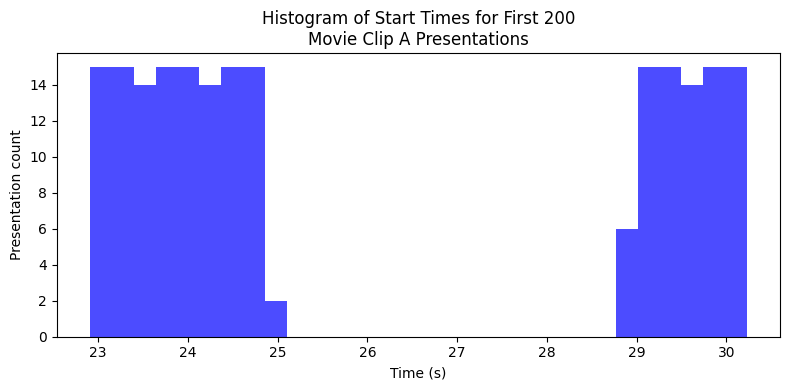

In [6]:
movie_A_intv = nwb.intervals["movie_clip_A_presentations"].to_dataframe()
start_times = movie_A_intv["start_time"].values[:200]

plt.figure(figsize=(8,4))
plt.hist(start_times, bins=30, color="blue", alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Presentation count")
plt.title("Histogram of Start Times for First 200\nMovie Clip A Presentations")
plt.tight_layout()
plt.show()

_The bimodal structure above reveals that presentations are grouped into repeated blocks or sessions rather than being uniformly scattered, highlighting the experiment's structure._

## Summary and Future Directions

This notebook demonstrated access, structural inspection, and visualization for Dandiset 000617 (Sequence Learning Project). Key points:
- The dataset features rich two-photon imaging data, processed ROI/cell segmentation, event and dF/F traces, and behavioral recordings.
- Several kinds of analysis are possible including population summary statistics, stimulus-triggered averaging, and decoding approaches.

**Possible next steps:**
- Link behavioral running speed to neural responses.
- Explore stimulus-locked averaging and single-cell selectivity.
- Compare different experiment days or stimulus identities.

Please refer to the raw and processed data for more sophisticated analyses and for temporal alignment with stimulus behavior.

**Remember:** This notebook is AI-generated; always critically validate code and outputs before basing further scientific conclusions on them.